# Import Packages

In [16]:
#Import packages
#The standard stuff
import re
import pandas as pd
import numpy as np
import string
from string import punctuation
import calendar
import sqlite3

#NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#If error, download the packages below
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

#Load SpaCy's large embedding model
import spacy 
nlp = spacy.load('en_core_web_lg')

#Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

# Import Data

In [15]:
#import data
data = pd.read_csv('data job posts.csv', encoding='iso-8859-1')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 24 columns):
jobpost             19001 non-null object
date                19001 non-null object
Title               18973 non-null object
Company             18994 non-null object
AnnouncementCode    1208 non-null object
Term                7676 non-null object
Eligibility         4930 non-null object
Audience            640 non-null object
StartDate           9675 non-null object
Duration            10798 non-null object
Location            18969 non-null object
JobDescription      15109 non-null object
JobRequirment       16479 non-null object
RequiredQual        18517 non-null object
Salary              9622 non-null object
ApplicationP        18941 non-null object
OpeningDate         18295 non-null object
Deadline            18936 non-null object
Notes               2211 non-null object
AboutC              12470 non-null object
Attach              1559 non-null object
Year              

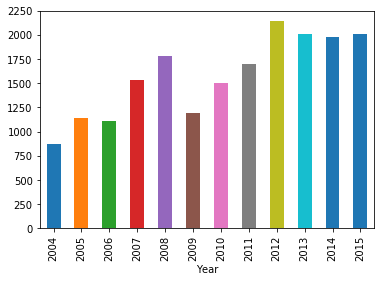

In [3]:
#View distribution by year
%matplotlib inline
data.groupby('Year')['Title'].count().plot(kind='bar')

# Parse JobPost

In [4]:
def parse_jobpost(text, key=None):
#Purpose: To parse information from jobpost
#Input:text; Return:dict
    job_output = dict()
    columns = ['Title', 
               'Position Duration', 
               'Position Location', 
               'Job Description',
               'Job Responsibilities',
               'Required Qualifications',
               'Remuneration', 
               'Application Deadline',
               'About Company'] 
    for i in columns:
        res = re.findall(r'{}:([^:]+)'.format(i), text, re.IGNORECASE)
        job_output[i] = ' '.join(res[0].split('\r\n')[:-1]).strip() if res else None
    
    return job_output if not key else job_output[key]

In [5]:
#calculate total rows in dataset
count_row = data.shape[0]
#Loop dataset to extract fields from jobpost. Change the range according to whichever rows that needed to be extracted. 
for x in range(0, 4):
    #input jobpost into function to extract fields. Output is a dictionary called job_dict
    data.jobpost[x]
    job_dict= parse_jobpost(data.jobpost[x])
    
    #print fields extracted from jobpost
    print ''
    print 'Job no', x+1  
    print 'Job Tittle:', job_dict.get('Title')
    print 'Position Duration:', job_dict.get('Position Duration')
    print 'Position Location:', job_dict.get('Position Location')
    print 'Job Description:', job_dict.get('Job Description')
    print 'Job Responsibilities:', job_dict.get('Job Responsibilities')
    print 'Required Qualifications:', job_dict.get('Required Qualifications')
    print 'Remuneration:', job_dict.get('Remuneration')
    print 'Application Deadline:', job_dict.get('Application Deadline')
    print 'About Company:', job_dict.get('About Company')


Job no 1
Job Tittle: Chief Financial Officer
Position Duration: None
Position Location: Yerevan, Armenia
Job Description: AMERIA Investment Consulting Company is seeking a Chief Financial Officer. This position manages the company's fiscal and administrative functions, provides highly responsible and technically complex staff assistance to the Executive Director. The work performed requires a high level of technical proficiency in financial management and investment management, as well as management, supervisory, and administrative skills.
Job Responsibilities: - Supervises financial management and administrative staff, including assigning responsibilities, reviewing employees' work processes and products, counseling employees, giving performance evaluations, and recommending disciplinary action; - Serves as member of management team participating in both strategic and operational planning for the company; - Directs and oversees the company's financial management activities, including

# Descriptive: No of JobAds

In [6]:
#Identify the company with the most number of job ads in the past 2 years
#Identify last 2 years
last_year = data.Year.max()
year = last_year - 1
#Get job ads count
print 'Top 10 company with the most job ads in the past two years from', year, '-', last_year
data[data['Year'] > year].Company.value_counts().nlargest(10)

Top 10 company with the most job ads in the past two years from 2014 - 2015


Mentor Graphics Development Services CJSC             36
Career Center NGO                                     36
"Coca-Cola Hellenic Bottling Company Armenia" CJSC    34
ArmenTel CJSC                                         33
Converse Bank CJSC                                    30
PicsArt LLC                                           30
Joomag AM LLC                                         30
BetArchitect LLC                                      28
Tumo Center for Creative Technologies                 28
Questrade International Inc., Armenian Branch         24
Name: Company, dtype: int64

In [7]:
#Identify the month with the largest number of job ads over the years
#Convert month int to month name
data['Months'] = data['Month'].apply(lambda x: calendar.month_abbr[x])
#Get job ads count by month
print 'Month with the largest number of ads over the years:'
month_ads_count = data.Months.value_counts()
print month_ads_count

Month with the largest number of ads over the years:
Mar    1702
Feb    1665
Jun    1662
Sep    1652
Oct    1637
Aug    1613
Jul    1595
May    1580
Nov    1573
Apr    1466
Dec    1432
Jan    1424
Name: Months, dtype: int64


# Preprocess Text: StopWords, Lemmatizer

In [8]:
#Clean text and generate new text from Job Responsibilities column.
#The new text shall not contain any stop words, and the plural words shall be converted into singular words.
def remove_stopwords (text):
#To remove stopwords from text.
#Input:text; Return:text
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    return ' '.join([x for x in word_tokens if x.lower() not in stop_words])
    
def convert_singular(text):
#To convert pural words to singular words. 
#Input:text; Return:text
    lmtzr = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    tokens = [token.lower() for token in word_tokens]
    return (' ').join([lmtzr.lemmatize(token) for token in tokens])

def combine_paragraph (sentences):
#To combine sentences into paragraph. First letter set tittle in sentence. 
#Input:list; Return:str
    results = list()
    for sentence in sentences:
        new_sentence = list()
        for n, w in enumerate(sentence.split(' ')):
            word = w.title() if n == 0 else w
            new_sentence.append(word)
        results.append((' ').join(new_sentence))
    return '.'.join(results)

def preprocess_parse_text(jobpost, key='Job Responsibilities'):
#To clean text from job responsibilities column.
#Input:text; Return:text
    text = parse_jobpost(jobpost, key)
    if not text:
        return None
    removed_stopwords = remove_stopwords(text)
    converted_singular = convert_singular(removed_stopwords)
    #split sentences 
    list_sentence = [sentence.strip() for sentence in converted_singular.split('.')]
    return combine_paragraph(list_sentence)

# Parse Job Responsibilities

In [9]:
#Preprocess text and save into dataframe
data['Job Responsibilities'] = data['jobpost'].apply(lambda x: preprocess_parse_text(x))

#Review
print 'Preprocessing Completed. Review below:'
data.head(10)

Preprocessing Completed. Review below:


,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT,Months,Job Responsibilities
0,AMERIA Investment Consulting Company\r\nJOB TI...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,26 January 2004,NaN,NaN,NaN,2004,1,False,Jan,- supervises financial management administrati...
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False,Jan,None
2,Caucasus Environmental NGO Network (CENN)\r\nJ...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\r\nPOSITION,...,NaN,20 January 2004\r\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\r\...,NaN,2004,1,False,Jan,- working country director provide environment...
3,Manoff Group\r\nJOB TITLE: BCC Specialist\r\n...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,23 January 2004\r\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False,Jan,- identify gap knowledge overseeing informatio...
4,Yerevan Brandy Company\r\nJOB TITLE: Software...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True,Jan,- rendering technical assistance database mana...
5,"Boutique ""Appollo""\r\nJOB TITLE: Saleswoman\r...","Jan 10, 2004",Saleswoman,"Boutique ""Appollo""",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,01 February 2004,NaN,NaN,NaN,2004,1,False,Jan,None
6,OSI Assistance Foundation - Armenian Branch Of...,"Jan 11, 2004",Chief Accountant/ Finance Assistant,OSI Assistance Foundation - Armenian Branch Of...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"16 January 2004, 6:00 pm.",NaN,NaN,NaN,2004,1,False,Jan,None
7,International Research & Exchanges Board (IREX...,"Jan 13, 2004",Non-paid part or full time Programmatic Intern,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,6 months,...,NaN,16 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False,Jan,None
8,Yerevan Brandy Company \r\nJOB TITLE: Assista...,"Jan 13, 2004",Assistant to Managing Director,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"27 January 2004, 18:00",NaN,NaN,NaN,2004,1,False,Jan,- coordinating work subordinate employee ; - m...
9,American Embassy Yerevan\r\nANNOUNCEMENT NUMBE...,"Jan 13, 2004","Program Assistant (INL), FSN-8; FP-6*",American Embassy Yerevan\r\nANNOUNCEMENT NUMBE...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,26 January 2004 \r\nDrafted: GSargsyan\r\nC...,NaN,NaN,NaN,2004,1,False,Jan,None


# Replace Null/NA

In [10]:
#Write functions to identify null/NA values and to replace null/NA values with a custom message in “Duration” column
#assume that Null/Na value equals to zero, thereforce replacing it with 0
custom_msg = 0
data['Duration'] = data['Duration'].fillna(custom_msg)
print 'Completed. Please review below:'
data['Duration'].head(n=10)

Completed. Please review below:


0                                        0
1                                 3 months
2    Renewable annual contract\r\nPOSITION
3                                        0
4                                        0
5                                        0
6                                        0
7                                 6 months
8                                        0
9                                        0
Name: Duration, dtype: object

# Store Results

In [12]:
#Export to CSV
data.to_csv('Q2_jobdata.csv', index=False)
data.head(n=10)

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT,Months,Job Responsibilities
0,AMERIA Investment Consulting Company\r\nJOB TI...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,0,...,NaN,26 January 2004,NaN,NaN,NaN,2004,1,False,Jan,- supervises financial management administrati...
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False,Jan,None
2,Caucasus Environmental NGO Network (CENN)\r\nJ...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\r\nPOSITION,...,NaN,20 January 2004\r\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\r\...,NaN,2004,1,False,Jan,- working country director provide environment...
3,Manoff Group\r\nJOB TITLE: BCC Specialist\r\n...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,0,...,NaN,23 January 2004\r\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False,Jan,- identify gap knowledge overseeing informatio...
4,Yerevan Brandy Company\r\nJOB TITLE: Software...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,0,...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True,Jan,- rendering technical assistance database mana...
5,"Boutique ""Appollo""\r\nJOB TITLE: Saleswoman\r...","Jan 10, 2004",Saleswoman,"Boutique ""Appollo""",NaN,NaN,NaN,NaN,NaN,0,...,NaN,01 February 2004,NaN,NaN,NaN,2004,1,False,Jan,None
6,OSI Assistance Foundation - Armenian Branch Of...,"Jan 11, 2004",Chief Accountant/ Finance Assistant,OSI Assistance Foundation - Armenian Branch Of...,NaN,NaN,NaN,NaN,NaN,0,...,NaN,"16 January 2004, 6:00 pm.",NaN,NaN,NaN,2004,1,False,Jan,None
7,International Research & Exchanges Board (IREX...,"Jan 13, 2004",Non-paid part or full time Programmatic Intern,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,6 months,...,NaN,16 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False,Jan,None
8,Yerevan Brandy Company \r\nJOB TITLE: Assista...,"Jan 13, 2004",Assistant to Managing Director,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,0,...,NaN,"27 January 2004, 18:00",NaN,NaN,NaN,2004,1,False,Jan,- coordinating work subordinate employee ; - m...
9,American Embassy Yerevan\r\nANNOUNCEMENT NUMBE...,"Jan 13, 2004","Program Assistant (INL), FSN-8; FP-6*",American Embassy Yerevan\r\nANNOUNCEMENT NUMBE...,NaN,NaN,NaN,NaN,NaN,0,...,NaN,26 January 2004 \r\nDrafted: GSargsyan\r\nC...,NaN,NaN,NaN,2004,1,False,Jan,None


In [ ]:
#Store the results in a new Dataframe/Sql table. 
#conn = sqlite3.connect('base_data_job_posts.sqlite.db')
#data.to_sql('base', conn)
#conn.close()